In [1]:
!nvidia-smi

Sun Jun 14 11:51:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:04:00.0 Off |                  N/A |
| 24%   44C    P2    61W / 250W |   2495MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 37%   61C    P2    77W / 250W |   6903MiB / 12189MiB |     54%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import os

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
torch.cuda.set_device(0)
import time

import torchvision
from torchvision import transforms as T

import tqdm


import warnings
warnings.filterwarnings('ignore')
torch.cuda.is_available()

True

In [4]:
path_data = '/home/user/michigan/data/AGM01/'
device = 'cuda'

In [5]:
root_dir = "/home/user/michigan/data/AGM01"
csv_file = "/home/user/michigan/data/AGM/AGM_Metadata.csv"
meta_data = pd.read_csv(csv_file)

In [6]:
meta_data.pop("Group_Index")
meta_data.drop_duplicates()

,Metadata_Image_Metadata_Compound,Metadata_Image_Metadata_Concentration,Metadata_PlateID,Metadata_WellID,COND
0,DMSO,0.000,Week1_22123,B02,NC
4,cytochalasin B,30.000,Week1_22123,B03,NaN
8,cytochalasin B,10.000,Week1_22123,B04,NaN
12,cytochalasin B,3.000,Week1_22123,B05,NaN
16,cytochalasin B,1.000,Week1_22123,B06,NaN
...,...,...,...,...,...
3580,PD-150606,0.500,Week9_39301,G07,NaN
3584,PD-150606,0.150,Week9_39301,G08,NaN
3588,PD-150606,0.050,Week9_39301,G09,NaN
3592,PD-150606,0.015,Week9_39301,G10,NaN


In [7]:
# week_id = "Single_Week1_22123"
# image_path = os.path.join(root_dir, week_id)
# image_files = np.array([x.path for x in os.scandir(image_path) if x.name.endswith(".tif")])

In [8]:
week_list=["Week1_22123"]
Week1_df = pd.read_csv(root_dir+"/features/"+week_list[0]+"_Joined.csv")

## Define Dataloader

In [9]:
class AGMDS(D.Dataset):
    def __init__(self, df, week, transform=None, channels=[0,1,2]):
        self.week = week
        self.df = df
        self.root_path = "/home/user/michigan/data/AGM01/"
        self.channels = channels
        self.img_dir = self.root_path+self.week
        self.len = df.shape[0]
        self.transforms = transform
        
    @staticmethod
    def _load_img_as_tensor(self, file_name):
        with Image.open(file_name) as img:
            img = img.resize((112,112),resample=Image.NEAREST)
            pixels = np.asarray(img)
            pixels = pixels.astype('float32')
            # Scale them to 0~1
            maxmum = pixels.max()
            pixels = pixels / maxmum
            return T.ToTensor()(pixels)

    def _get_img_path(self, index, channel):
        well, field, cell_idx = self.df.iloc[index]["Metadata_WellID_Nuclei"], self.df.iloc[index]["Metadata_FieldID_Nuclei"], self.df.iloc[index]["ObjectNumber_Nuclei"]
        return "/home/user/michigan/data/AGM01/Single_%s/%s_%s_%s_%s.tif" % (self.week, well, field, ("Ch" + str(channel)), cell_idx)
    
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        img = torch.cat([self._load_img_as_tensor(self, img_path) for img_path in paths])
        return img, self.df.iloc[index]["Metadata_WellID_Nuclei"] 

    def __len__(self):
        return self.len
    

In [10]:
AGMData = AGMDS(df = Week1_df, week = week_list[0])


## Define model structure

In [11]:
def model(latent_dims = 8, capacity = 32, variational_beta = 1):
    
    class Encoder(nn.Module):
        def __init__(self):
            super(Encoder, self).__init__()
            c = capacity
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 56 x 56
            self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: 2c x 28 x 28
            self.fc_mu = nn.Linear(in_features=c*2*28*28, out_features=latent_dims)
            self.fc_logvar = nn.Linear(in_features=c*2*28*28, out_features=latent_dims)

        def forward(self, x):
            x = F.sigmoid(self.conv1(x))
            x = F.sigmoid(self.conv2(x))
            x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
            x_mu = self.fc_mu(x)
            x_logvar = self.fc_logvar(x)
            return x_mu, x_logvar

    class Decoder(nn.Module):
        def __init__(self):
            super(Decoder, self).__init__()
            c = capacity
            self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*28*28)
            self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
            self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)

        def forward(self, x):
            x = self.fc(x)
            x = x.view(x.size(0), capacity*2, 28, 28) # unflatten batch of feature vectors to a batch of multi-channel feature maps
            x = F.sigmoid(self.conv2(x))
            x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
            return x

    class VariationalAutoencoder(nn.Module):
        def __init__(self):
            super(VariationalAutoencoder, self).__init__()
            self.encoder = Encoder()
            self.decoder = Decoder()

        def forward(self, x):
            latent_mu, latent_logvar = self.encoder(x)
            latent = self.latent_sample(latent_mu, latent_logvar)
            x_recon = self.decoder(latent)
            return x_recon, latent_mu, latent_logvar

        def latent_sample(self, mu, logvar):
            if self.training:
                # the reparameterization trick
                std = logvar.mul(0.5).exp_()
                eps = torch.empty_like(std).normal_()
                return eps.mul(std).add_(mu)
            else:
                return mu

    def vae_loss(recon_x, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 112*112), x.view(-1, 112*112), reduction='sum')

        # KL-divergence between the prior distribution over latent vectors
        # (the one we are going to sample from when generating new images)
        # and the distribution estimated by the generator for the given image.
        kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss + variational_beta * kldivergence
    

    vae = VariationalAutoencoder().to(device)

    num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
    print('Number of parameters: %d in latent size: %d' % (num_params, latent_dims))
    return vae



In [12]:
latent_dims = 128
vae = model(latent_dims = latent_dims)

Number of parameters: 19386755 in latent size: 128


In [13]:
latent_dims = 32
vae = model(latent_dims = latent_dims)

Number of parameters: 4935875 in latent size: 32


In [18]:
latent_dims = 64
vae = model(latent_dims = latent_dims)

Number of parameters: 9752835 in latent size: 64


In [16]:
latent_dims = 8
vae = model(latent_dims = latent_dims)

Number of parameters: 1323155 in latent size: 8


## Training

In [19]:
batch_size = 64
learning_rate = 1e-3

loader = D.DataLoader(AGMData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [20]:
for i in os.listdir():
    if i == "model%s.pt" % latent_dims:
        vae.load_state_dict(torch.load(i))
        vae.to(device)
    if i == "opt%s.pt" % latent_dims:
        optimizer.load_state_dict(torch.load(i))


In [41]:
train_loss = []
num_epochs = 2
print('Training ...')
tlen = len(loader)
batch_idx = 0
try:
    for epoch in range(num_epochs):
        
        for j, (image_batch, label) in enumerate(loader): # image_batch is a batch (16) of 3 channels images tensor; 
            image_batch = image_batch.to(device)
            #vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)         
            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
#             if j ==6:
#                 break
            train_loss.append(loss.item())
            if j % 100 == 0:
                result = "[%d/%d][%d/%d]\tLoss:%f\tlatent_dims:%d\t%s\n" % (epoch, num_epochs, j, len(loader),
                                                   np.cumsum(train_loss)[len(train_loss)-1]/len(train_loss), latent_dims, time.ctime())
                print(result)
                f=open("vae_AGM_train%s.log"% latent_dims, "a")
                f.write(result)
                f.close
        torch.save(vae.state_dict(), "model%s.pt" % latent_dims)
        torch.save(optimizer.state_dict(), "opt%s.pt" % latent_dims)
except KeyboardInterrupt:
    print("Interrupting... Saving model...")
    torch.save(vae.state_dict(), "model%s.pt" % latent_dims)
    torch.save(optimizer.state_dict(), "opt%s.pt" % latent_dims)


Training ...
[0/2][0/422]	Loss:1994270.625000	latent_dims:128	Tue May 26 09:50:23 2020

[0/2][200/422]	Loss:1667203.649254	latent_dims:128	Tue May 26 10:17:04 2020

[0/2][300/422]	Loss:1630507.857143	latent_dims:128	Tue May 26 10:32:33 2020

[0/2][400/422]	Loss:1607956.091334	latent_dims:128	Tue May 26 10:49:06 2020

[1/2][0/422]	Loss:1603191.179521	latent_dims:128	Tue May 26 10:52:42 2020

[1/2][100/422]	Loss:1591993.432481	latent_dims:128	Tue May 26 11:09:36 2020

[1/2][200/422]	Loss:1582837.460373	latent_dims:128	Tue May 26 11:23:02 2020

[1/2][300/422]	Loss:1577706.400501	latent_dims:128	Tue May 26 11:33:25 2020

[1/2][400/422]	Loss:1572596.303235	latent_dims:128	Tue May 26 11:41:54 2020



## Reconstruct images

In [21]:
images, well = iter(loader).next()

In [22]:
def show_image(img):
#     img = to_img(img)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Original images


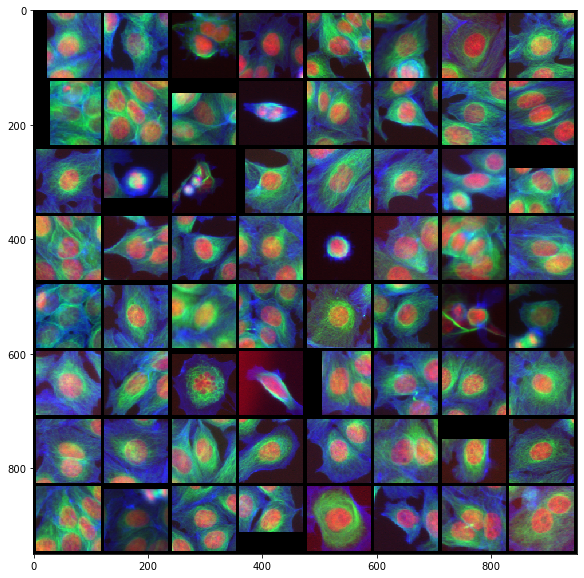

In [23]:
print('Original images')
plt.figure(figsize=(10, 10))
show_image(torchvision.utils.make_grid(images,8,6))
plt.show()

In [24]:
def show_result(latent, images):
    latent_dims = latent
    vae = model(latent_dims = latent_dims)
    for i in os.listdir():
        if i == "model%s.pt" % latent_dims:
            vae.load_state_dict(torch.load(i))
            vae.to(device)

#     print('VAE reconstruction:')
    with torch.no_grad():
#         plt.figure(figsize=(10, 10))
        images = images.to(device)
        recon_images, _, _ = vae(images)
        recon_images = recon_images.cpu()
    #     recon_images = to_img(recon_images)
        np_imagegrid = torchvision.utils.make_grid(recon_images, 8, 8).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
#         plt.show()

Number of parameters: 1323155 in latent size: 8
Number of parameters: 4935875 in latent size: 32
Number of parameters: 9752835 in latent size: 64


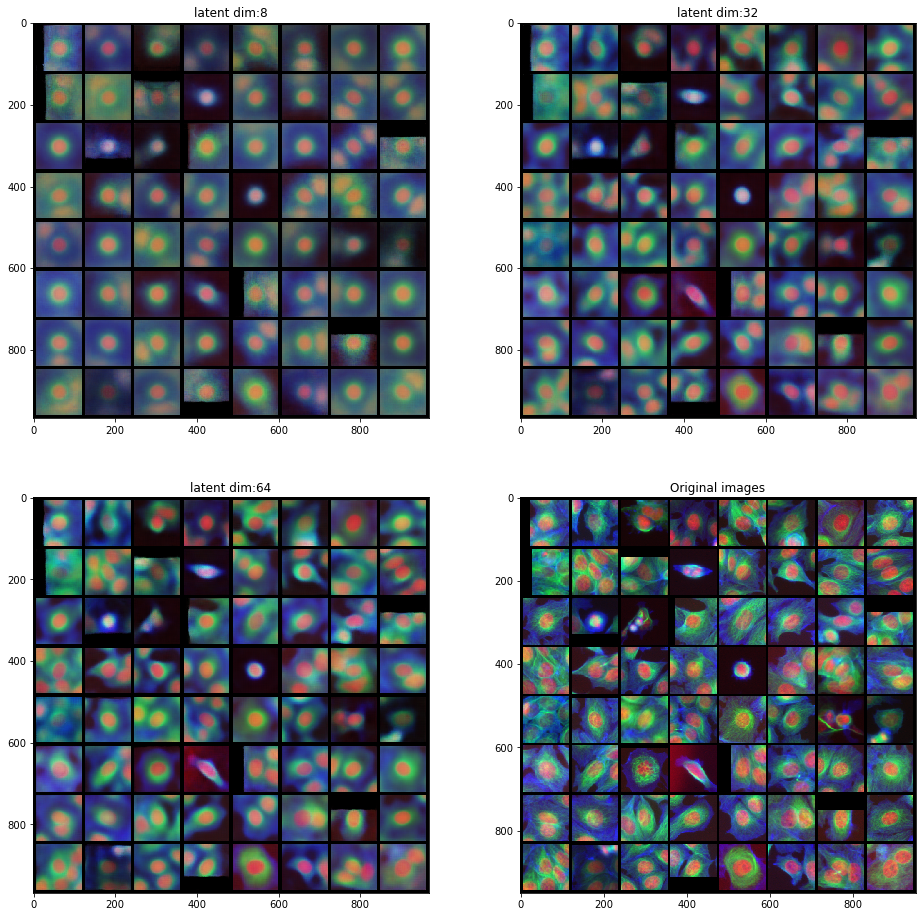

In [25]:
dim_list = [8,32,64,128]
plt.figure(figsize=(16, 16))
for i in range(3):
    ax = plt.subplot(2,2,i+1)
    show_result(dim_list[i], images)
    ax.set_title("latent dim:%d" % dim_list[i])
ax = plt.subplot(2,2,4)
show_image(torchvision.utils.make_grid(images,8,6))
ax.set_title("Original images")
plt.show()

# Distribution in reduced latent space

In [32]:
from sklearn.decomposition import PCA

In [26]:
code_well = pd.read_csv("code_data337.csv")

In [27]:
code_well.pop("Unnamed: 0")

0         0
1         1
2         2
3         3
4         4
         ..
26980    20
26981    21
26982    22
26983    23
26984    24
Name: Unnamed: 0, Length: 26985, dtype: int64

In [33]:
PC_code_well = code_well[code_well["64"]=="B02"]
NC_code_well = code_well[code_well["64"]=="B11"]
cytoB_code_well = code_well[code_well["64"]=="B06"]

In [128]:
pca=PCA(n_components=2)   
code = code_well[["%d"% i for i in range(64)]]
reduced_x=pca.fit_transform(code)

In [30]:
red_x,red_y=[],[]
blue_x,blue_y=[],[]
green_x,green_y=[],[]

In [35]:
for i in range(len(reduced_x)):
    if y[i] =="B02":
        red_x.append(reduced_x[i][0])
        red_y.append(reduced_x[i][1])

    elif y[i]=="B11":
        blue_x.append(reduced_x[i][0])
        blue_y.append(reduced_x[i][1])
        
    elif y[i]=="B06":
        green_x.append(reduced_x[i][0])
        green_y.append(reduced_x[i][1])


NameError: name 'y' is not defined

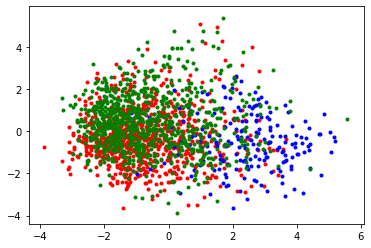

In [115]:
plt.scatter(red_x,red_y,c='r',marker='.')
plt.scatter(blue_x,blue_y,c='b',marker='.')
plt.scatter(green_x,green_y,c='g',marker='.')
plt.show()


# Centroid reconstruction and interpolation

In [28]:
def ArrayRange(a, b, step):
    if a > b:
        return np.append(np.arange(b, a, (a-b)/(step-1)), a)[::-1]
    if a < b:
        return np.append(np.arange(a, b, (b-a)/(step-1)), b)

In [95]:
ArrayRange(PC_code_well.mean()[0], NC_code_well.mean()[0], 10)

array([ 0.22662404,  0.19268925,  0.15875446,  0.12481966,  0.09088487,
        0.05695008,  0.02301528, -0.01091951, -0.04485431, -0.0787891 ])

In [100]:
latents = np.column_stack([ArrayRange(PC_code_well.mean()[i], NC_code_well.mean()[i], 10) for i in range(64)])

In [101]:
latents.shape

(10, 64)

In [221]:
def reconstruct(code, model):
    if len(torch.tensor(code, dtype=torch.float32).to(device).shape) == 1:
        code = torch.stack([torch.tensor(code, dtype=torch.float32).to(device)])
    else:
        code = torch.tensor(code, dtype=torch.float32).to(device)
    image_recon = model.decoder(code)
    recon_images = image_recon.cpu().detach()
    np_imagegrid = torchvision.utils.make_grid(recon_images, 10).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

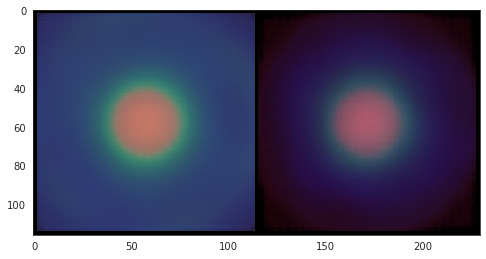

In [222]:
plt.figure(figsize=(8, 8))
reconstruct(np.array([latents[0],latents[9]]),vae)

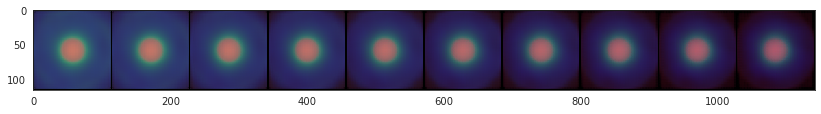

In [224]:
plt.figure(figsize=(14, 14))
reconstruct(latents, vae)

# PC and NC samples reconstruction and interpolation

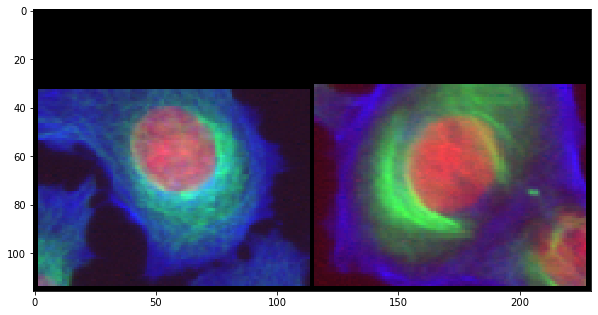

In [44]:
plt.figure(figsize=(10, 10))
np_imagegrid = torchvision.utils.make_grid(torch.stack([AGMData[2][0],AGMData[5523][0]]),2).numpy()
plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
plt.show()

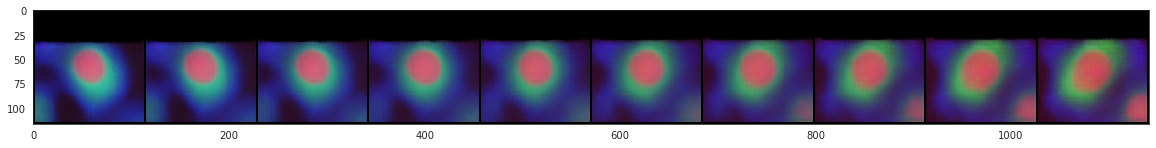

In [225]:
codes = vae(torch.stack([AGMData[2][0], AGMData[5523][0]]).to(device))[1].cpu().detach().numpy()
latents = np.column_stack([ArrayRange(codes[0][i], codes[1][i], 10) for i in range(64)])
plt.figure(figsize=(20, 20))
reconstruct(latents, vae)

In [49]:
import seaborn as sns

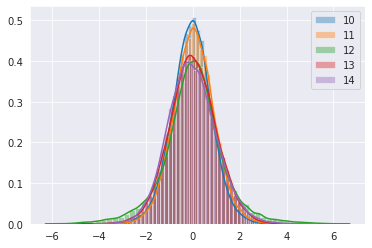

In [62]:
sns.set_style('darkgrid')
for i in code_well.columns[10:15]:
    sns.distplot(code_well[[i]], label = i)
plt.legend()


In [ ]:
sns.distplot( df["sepal_length"] , color="skyblue", label="Sepal Length");
sns.distplot( df["sepal_width"] , color="red", label="Sepal Width");
plt.legend()

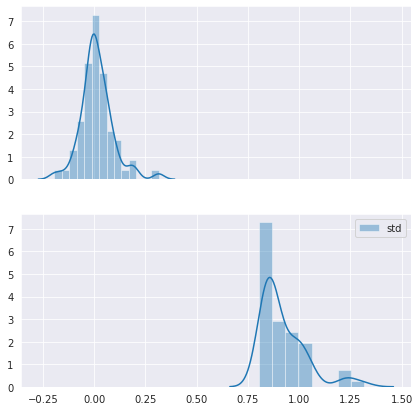

In [85]:
f, axes = plt.subplots( 2, figsize=(7, 7), sharex=True)
sns.distplot(code_well.mean(), label = "mean", ax=axes[0])
sns.distplot(code_well.std(), label = "std", ax=axes[1])
plt.legend()
sns.set_style("white")

In [172]:
code = code_well[["%d"% i for i in range(64)]]

In [277]:
def interpolate(cell_code, cell_idx, model, dim, dim_len):
    code = cell_code
    c2 = np.array(code.iloc[cell_idx])
    left_code = np.array([c2[:(dim-1)] for i in range(dim_len)])
    right_code = np.array([c2[dim:] for i in range(dim_len)])
    code = np.column_stack([left_code, ArrayRange(code[str(dim-1)].min(), code[str(dim-1)].max(), dim_len), right_code])
    code = torch.tensor(code, dtype=torch.float32).to(device)
    image_recon = model.decoder(code)
    recon_images = image_recon.cpu().detach()
    np_imagegrid = torchvision.utils.make_grid(recon_images, dim_len).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))

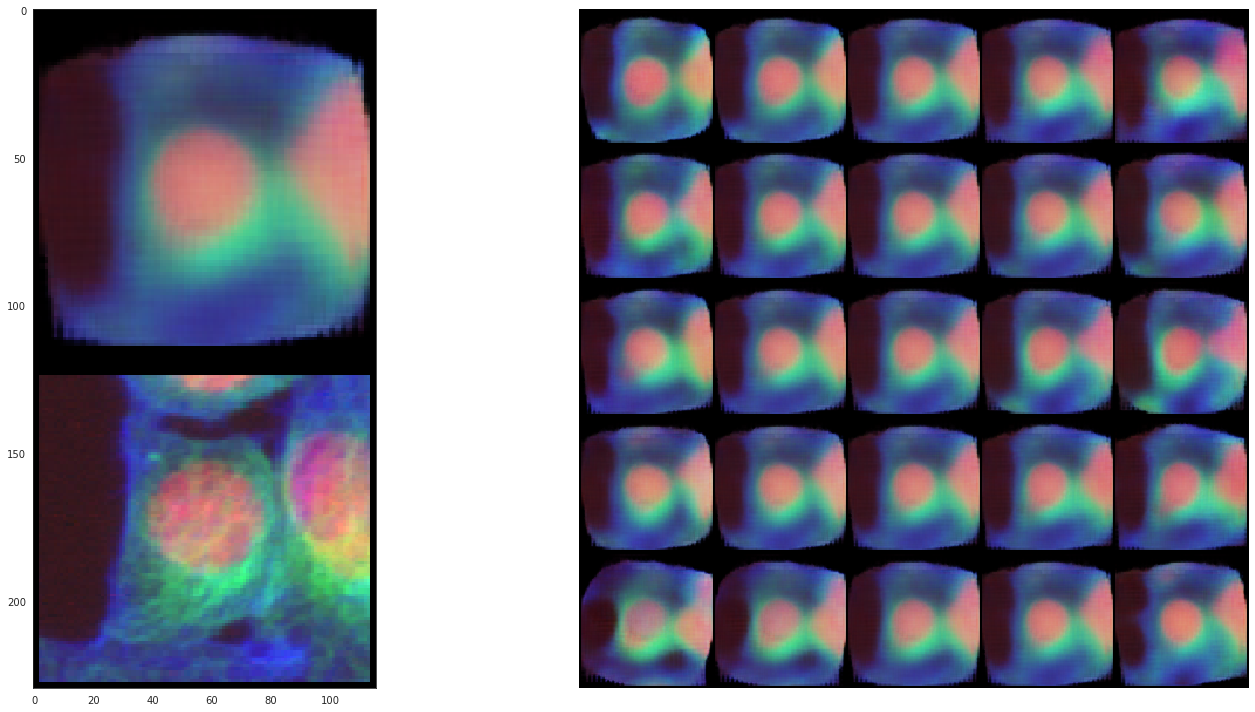

In [285]:
def interpolate_plot(idx, dim, dim_len, code):
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(1,2,1)
    recon_images = vae.decoder(torch.stack([torch.tensor(code.iloc[idx], dtype=torch.float32).to(device)])).cpu().detach()
    np_imagegrid = torchvision.utils.make_grid([recon_images[0],AGMData[idx][0]], 1,2).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))


    for i in range(dim_len):
        ax = plt.subplot(dim_len,2,(i+1)*2)
        plt.axis('off')
        plt.tight_layout()
        plt.subplots_adjust(wspace = 0,hspace = 0)
        interpolate(code, idx, vae, dim+i, dim_len)
        
interpolate_plot(5, 5, 5, code_well[["%d"% i for i in range(64)]])